# Embeddings to test

* UMAP
* t-SNE
* Parametric UMAP (part of UMAP)
* DenseMap (part of UMAP)
* [PacMap](https://github.com/YingfanWang/PaCMAP)
* [TriMap](https://github.com/eamid/trimap)
* PCA
* Laplacian eigenmaps
* MDS
* Isomap
* [MDE](https://github.com/cvxgrp/pymde)
* [PHATE](https://github.com/KrishnaswamyLab/PHATE)
* ForceAtlas2
* dbMAP


# Experiments

* distance/distance-rank preservation with varying ```n_neighbors```, ```n_components``` and ```min_dist```, measured with Pearson's corr.
* hierarchical embedding: original -> 1000d -> 100d -> 2d
* negative test: does it magically create clusters? Test using a high dimensional Gaussian


Metrics:
* Spearman rank correlation between samples
* Pearson correlation of distances
* Distance correlation of distances
* Average Jaccard distance


In [1]:
%load_ext autoreload
%autoreload 1
%aimport omic_helpers
%matplotlib inline

from omic_helpers import graph_clustering


from sklearn import datasets
from sklearn.preprocessing import StandardScaler, QuantileTransformer, RobustScaler, MinMaxScaler, FunctionTransformer
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chisquare, chi2_contingency, pearsonr
from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
from scipy.spatial import distance
import dcor

import umap
import pacmap
import trimap
import pymde
import dbmap

import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA, KernelPCA, NMF
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE
from tqdm import tqdm

import gc

None
None


In [2]:
def get_intra_sample_distances(X, how='euclidean'):
    if how == 'euclidean':  
        return distance.pdist(X)

In [3]:
# [x] Sammon mapping: https://arxiv.org/pdf/2009.08136.pdf
# opt-SNE: https://github.com/omiq-ai/Multicore-opt-SNE
# maximum variance unfolding 
# FastMap MDS: https://github.com/shawn-davis/FastMapy
# Landmark MDS

# Local Multidimensional scaling
# RankVisu
# GSOM: https://github.com/CDAC-lab/pygsom/tree/master/gsom
# MetricMap
# SparseMap: https://github.com/vene/sparsemap
# growing curvilinear component analysis
# curvilinear distance analysis
# diffeomorphic dimensionality reduction Diffeomap
# autoencoder NeuroScale
# PHATE
# GPLVM
# FA
# Nonlinear PCA
# SDNE 
# GCN

# NN-graph/Parametric UMAP -> GraphSage/Node2Vec/etc.. see NetworkX and karateclub!
# https://github.com/benedekrozemberczki/karateclub

# https://github.com/palash1992/GEM-Benchmark

In [4]:
def generate_2d_test_sets(**kwargs):
    
    transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
    
    sets = []
    mcluster = datasets.make_blobs(n_samples=1000, n_features=3, centers=[(-10,-10), (10,10), (-10,10), (10,-10)], 
                                cluster_std=[1., 0.5, 1.5, 0.75])[0]
    mcluster = StandardScaler().fit_transform(mcluster)
    sets.append(mcluster)
    #####################
    mcluster = datasets.make_circles(n_samples=1000, factor=.4, noise=.01)[0]
    mcluster = StandardScaler().fit_transform(mcluster)
    sets.append(mcluster)
    #####################
    mcluster = datasets.make_s_curve(n_samples=1000, noise=.2)[0]
    mcluster = StandardScaler().fit_transform(mcluster)[:,[0,2]]    
    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)
    #####################
    mcluster = datasets.make_moons(n_samples=1000, noise=.1)[0]
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    sets.append(mcluster)
    #####################
    mcluster = datasets.make_blobs(n_samples=1000, centers=3, cluster_std=[1., 0.5, 1.5])[0]
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    sets.append(mcluster)
    #####################
    mcluster = datasets.make_blobs(n_samples=1000, centers=4, cluster_std=[1., 0.5, 1.5, 0.75])[0]
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)
    #####################
    x = np.random.lognormal(mean=0., sigma=0.25, size=1000)
    y = -0.3/x**3 + np.random.normal(loc=0., scale=0.1, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])

    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)
    #####################
    x = np.random.lognormal(mean=0., sigma=0.25, size=1000)
    y = 2*x**2 + np.random.normal(loc=0., scale=0.1, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])

    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)
    #####################
    x = np.random.normal(loc=0, scale=0.5, size=1000)
    y = 2*x**2 + np.random.uniform(low=-0.5, high=0.5, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])

    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    sets.append(mcluster)
    #####################
    x = np.random.normal(loc=0, scale=0.5, size=1000)
    y = -2*x**2 + np.random.uniform(low=-0.5, high=0.5, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])

    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    sets.append(mcluster)
    #####################
    x = np.random.normal(loc=0.1, scale=0.5, size=1000)
    y = 2*x**2 + np.random.uniform(low=-0.5, high=0.5, size=1000)
    mcluster1 = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster1 = StandardScaler().fit_transform(mcluster1)[:,:]

    x = np.random.normal(loc=-0.1, scale=0.5, size=1000)
    y = -2*x**2 + np.random.uniform(low=-0.5, high=0.5, size=1000)
    mcluster2 = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster2 = StandardScaler().fit_transform(mcluster2)[:,:]
    mcluster = np.vstack([mcluster1, mcluster2])
    sets.append(mcluster)
    ####################
    x = np.random.normal(loc=0.1, scale=0.4, size=1000)
    y = np.sin(4*x) + np.random.uniform(low=-0.2, high=0.2, size=1000)
    mcluster1 = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster1 = StandardScaler().fit_transform(mcluster1)[:,:]

    x = np.random.normal(loc=-0.1, scale=0.4, size=1000)
    y = np.sin(4*x) + np.random.uniform(low=-0.2, high=0.2, size=1000)
    mcluster2 = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster2 = StandardScaler().fit_transform(mcluster2)[:,:]
    mcluster = np.vstack([mcluster1, mcluster2])
    sets.append(mcluster)
    ####################
    x = np.random.normal(loc=0.1, scale=0.4, size=1000)
    y = -np.sin(4*x) + np.random.uniform(low=-0.3, high=0.3, size=1000)
    mcluster1 = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster1 = StandardScaler().fit_transform(mcluster1)[:,:]

    x = np.random.normal(loc=-0.1, scale=0.4, size=1000)
    y = np.sin(4*x) + np.random.uniform(low=-0.3, high=0.3, size=1000)
    mcluster2 = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster2 = StandardScaler().fit_transform(mcluster2)[:,:]

    mcluster = np.vstack([mcluster1, mcluster2])
    sets.append(mcluster)
    ###################
    x = np.random.normal(loc=0.0, scale=0.5, size=1000)
    y = x*np.sin(8*x+1) + np.random.uniform(low=-0.4, high=0.4, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)    
    ###################
    x = np.random.normal(loc=0.0, scale=0.5, size=1000)
    y = np.random.normal(loc=0.0, scale=0.5, size=1000) # np.random.uniform(low=-0.4, high=0.4, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    sets.append(mcluster)
    ###################
    transformation = [[0.95, -0.33667341], [-0.30887718, 0.95]]
    x = np.random.uniform(low=-0.4, high=0.4, size=1000) # np.random.normal(loc=0.0, scale=0.5, size=1000)
    y = np.random.uniform(low=-0.4, high=0.4, size=1000) # np.random.normal(loc=0.0, scale=0.5, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)
    ###################
    transformation = [[0.95, 0.33667341], [0.30887718, 0.95]]
    x = np.random.uniform(low=-0.4, high=0.4, size=1000) # np.random.normal(loc=0.0, scale=0.5, size=1000)
    y = np.random.uniform(low=-0.4, high=0.4, size=1000) # np.random.normal(loc=0.0, scale=0.5, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)
    ###################
    transformation = [[0.7071, -0.7071], [0.7071, 0.7071]]

    x = np.random.uniform(low=-0.4, high=0.4, size=1000) # np.random.normal(loc=0.0, scale=0.5, size=1000)
    y = np.random.uniform(low=-0.4, high=0.4, size=1000) # np.random.normal(loc=0.0, scale=0.5, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]

    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)
    
    return sets, kwargs



## Local correlations

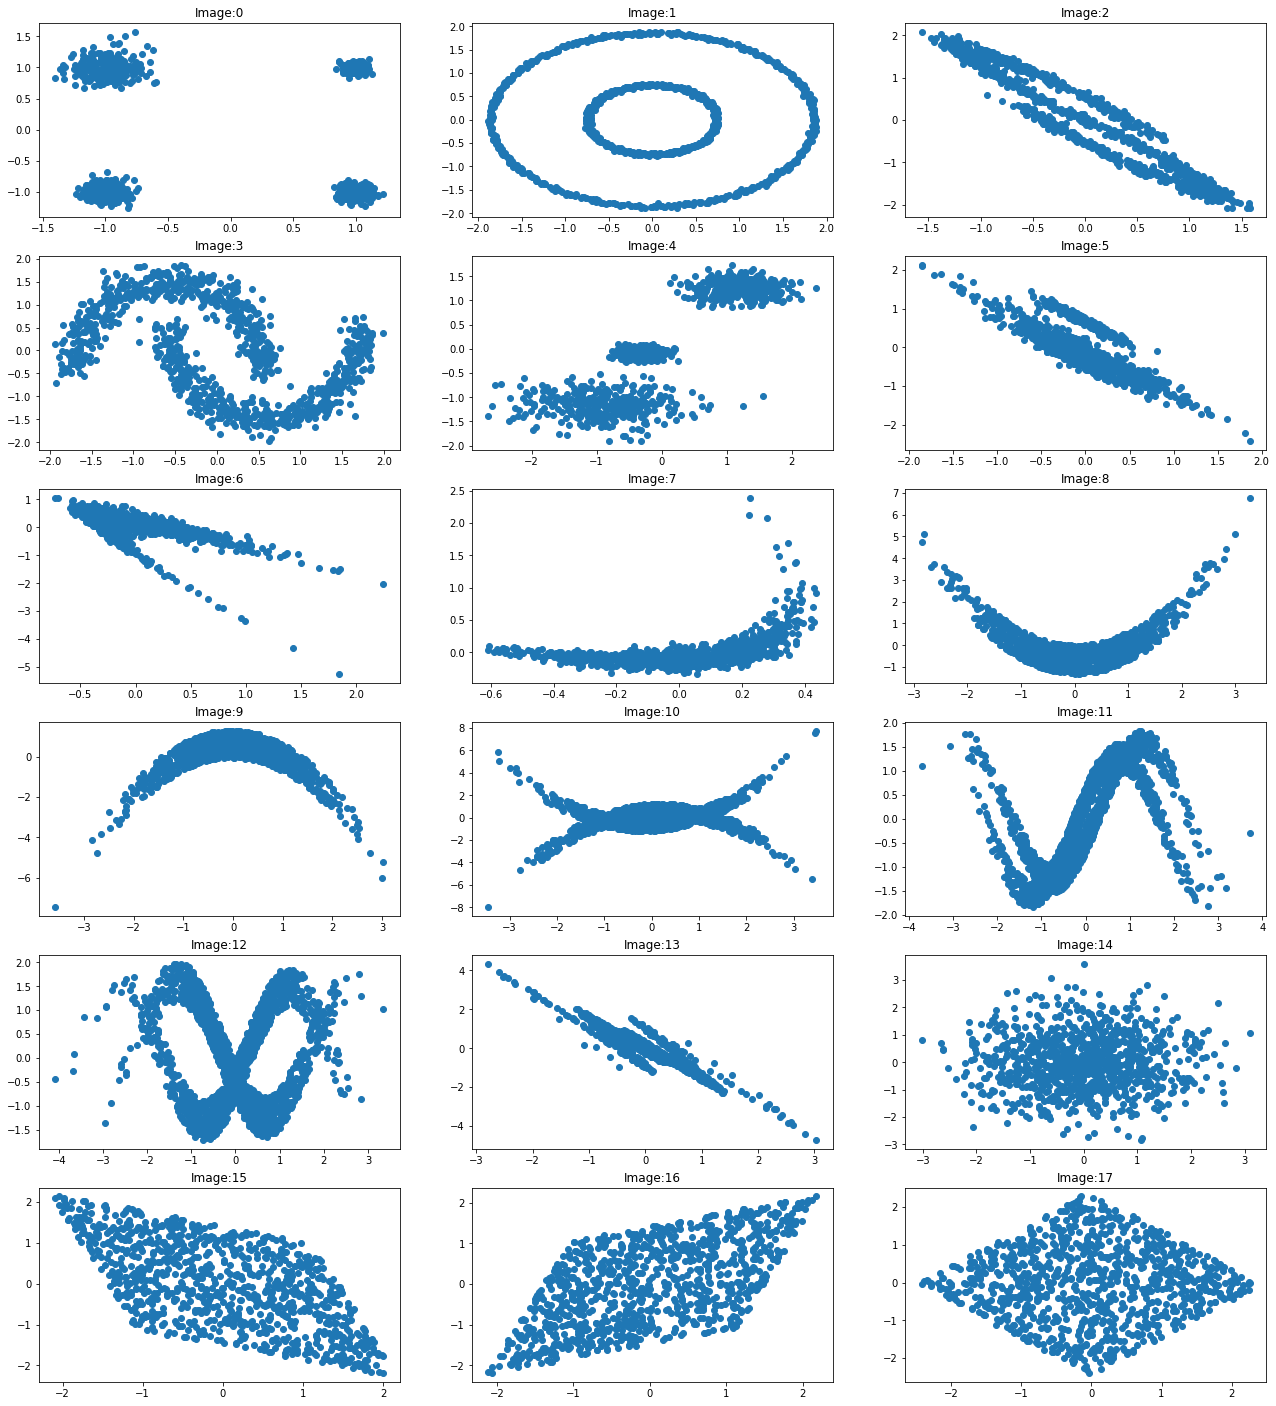

In [5]:
test_sets = generate_2d_test_sets()[0]
fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(22,25))
for k, ds in enumerate(test_sets):
    j=k%3 
    i=int(k/3)
    ax[i,j].scatter(x=ds[:,0], y=ds[:,1])
    ax[i,j].set_title(f'Image:{k}')

In [6]:
from tqdm import tqdm
from scipy.sparse import csr_matrix

In [36]:
embedder_type = 'umap'

embedder = {}
embedder['umap'] = umap.UMAP(n_components=2, densmap=True, metric='l2', n_neighbors=25, min_dist=0.)
embedder['trimap'] = trimap.TRIMAP(n_dims=2, n_iters=750)
embedder['pacmap'] = pacmap.PaCMAP(n_dims=2, n_neighbors=50)
embedder['SpectralEmbedding'] = SpectralEmbedding(n_components=2, n_neighbors=99)
embedder['Isomap'] = Isomap(n_components=2)
embedder['MDS'] = MDS(n_components=2)
embedder['KernelPCA'] = KernelPCA(n_components=2)
embedder['PCA'] = PCA(n_components=2)
embedder['dbmap'] = dbmap.diffusion.Diffusor(n_components=120, ann_dist='euclidean')
embedder['LLE'] = LLE(n_components=2, n_neighbors=51, method='hessian') # ltsa
embedder['NMF'] = NMF(n_components=2, max_iter=2000) 
embedder['Sammon'] = graph_clustering.Sammon(n_components=2, n_neighbors=25,
                                            max_iterations=250, learning_rate=0.1, init_type='PCA')

test_sets_embedded = []
if embedder_type == 'dbmap':
    for ts in tqdm(test_sets):
        tts = embedder['dbmap'].fit_transform(ts)
        test_sets_embedded.append(np.array(embedder['umap'].fit_transform(tts)))
elif embedder_type == 'NMF':
    for ts in tqdm(test_sets):
        tts = ts + np.abs(np.min(ts, axis=0))
        test_sets_embedded.append(np.array(embedder['NMF'].fit_transform(tts)))    
else:
    for ts in tqdm(test_sets):
        test_sets_embedded.append(np.array(embedder[embedder_type].fit_transform(ts)))

  0%|          | 0/18 [00:00<?, ?it/s]

TRIMAP(n_inliers=10, n_outliers=5, n_random=5, distance=euclidean, lr=1000.0, n_iters=750, weight_adj=500.0, apply_pca=True, opt_method=dbd, verbose=True, return_seq=False)


100%|██████████| 18/18 [02:39<00:00,  8.85s/it]


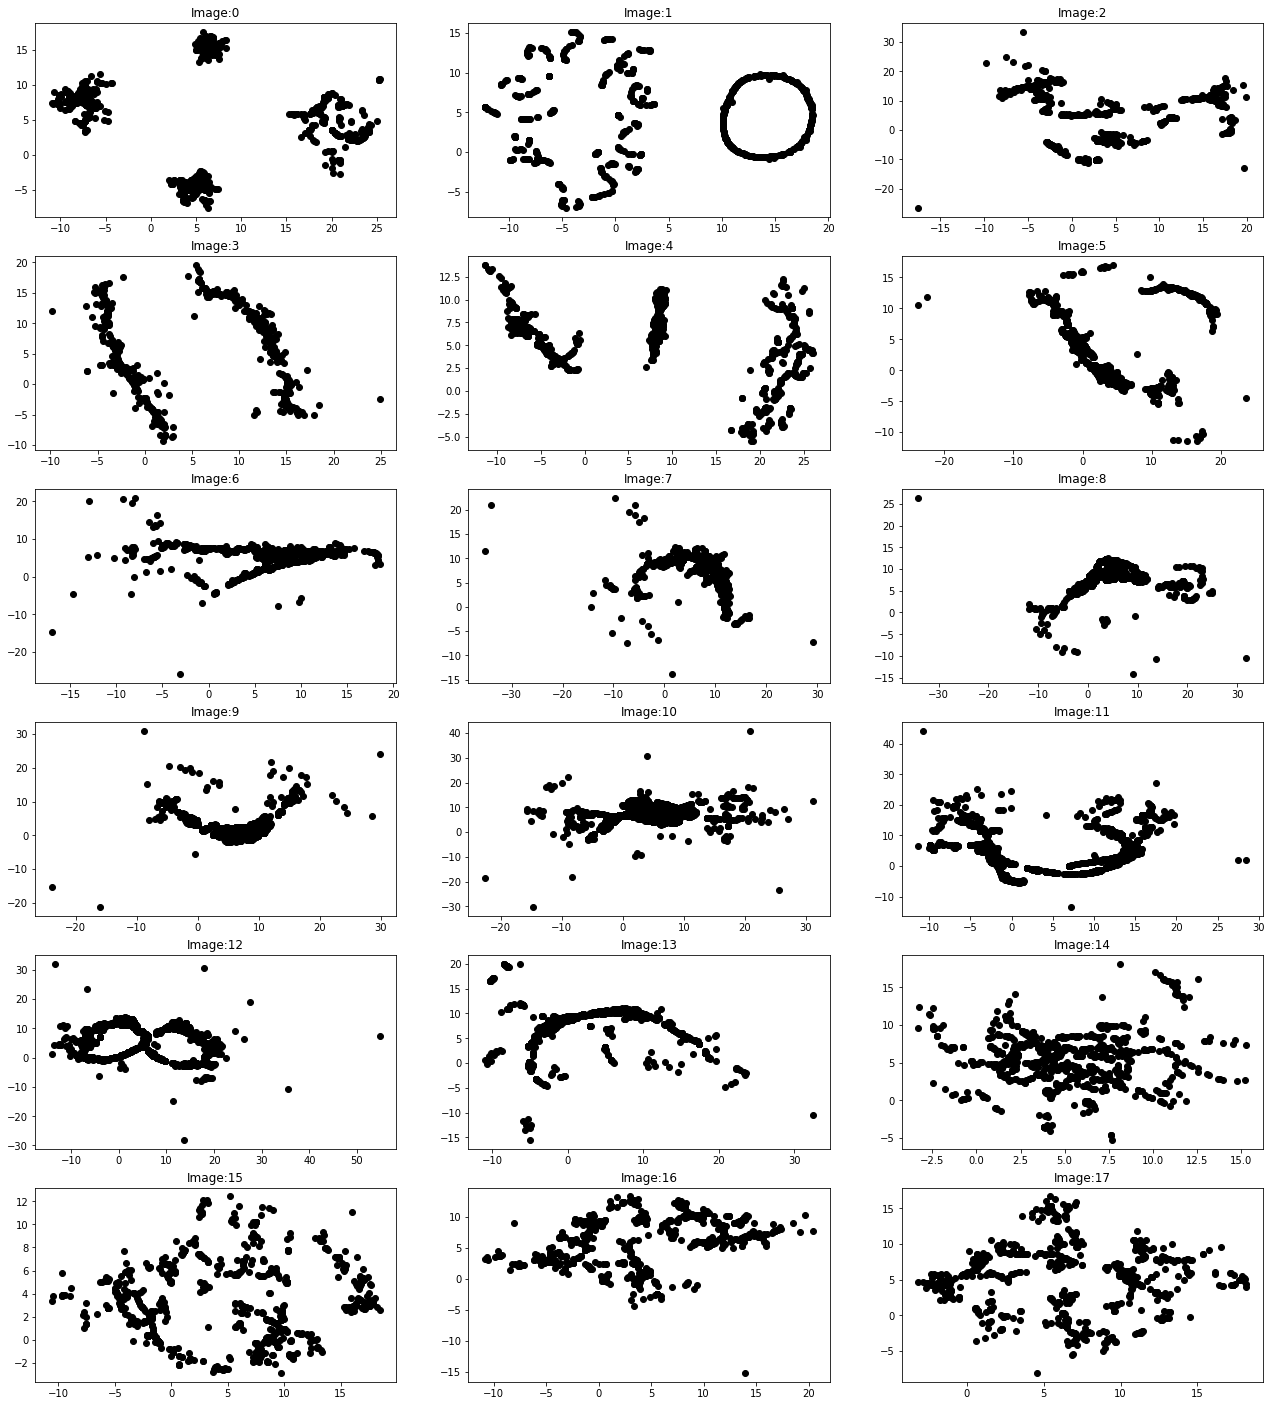

In [37]:
fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(22,25))
for k, ds in enumerate(test_sets_embedded):
    j=k%3 
    i=int(k/3)
    ax[i,j].scatter(x=ds[:,0], y=ds[:,1], color='black')
    ax[i,j].set_title(f'Image:{k}')

In [38]:
num_samples = 1000
sample_size = 100

dist_preservation = []
dists = []
for num in tqdm(range(0,18)):
    sample_selection = np.random.randint(0,num_samples, sample_size)
    dist_or = get_intra_sample_distances(test_sets[num][sample_selection,:])
    dist_emb = get_intra_sample_distances(test_sets_embedded[num][sample_selection,:])

    dists.append({'d_or': dist_or, 'd_emb': dist_emb})
    dist_preservation.append({'dataset': num , 'corr':spearmanr(dist_or, dist_emb)[0]})

100%|██████████| 18/18 [00:00<00:00, 522.97it/s]


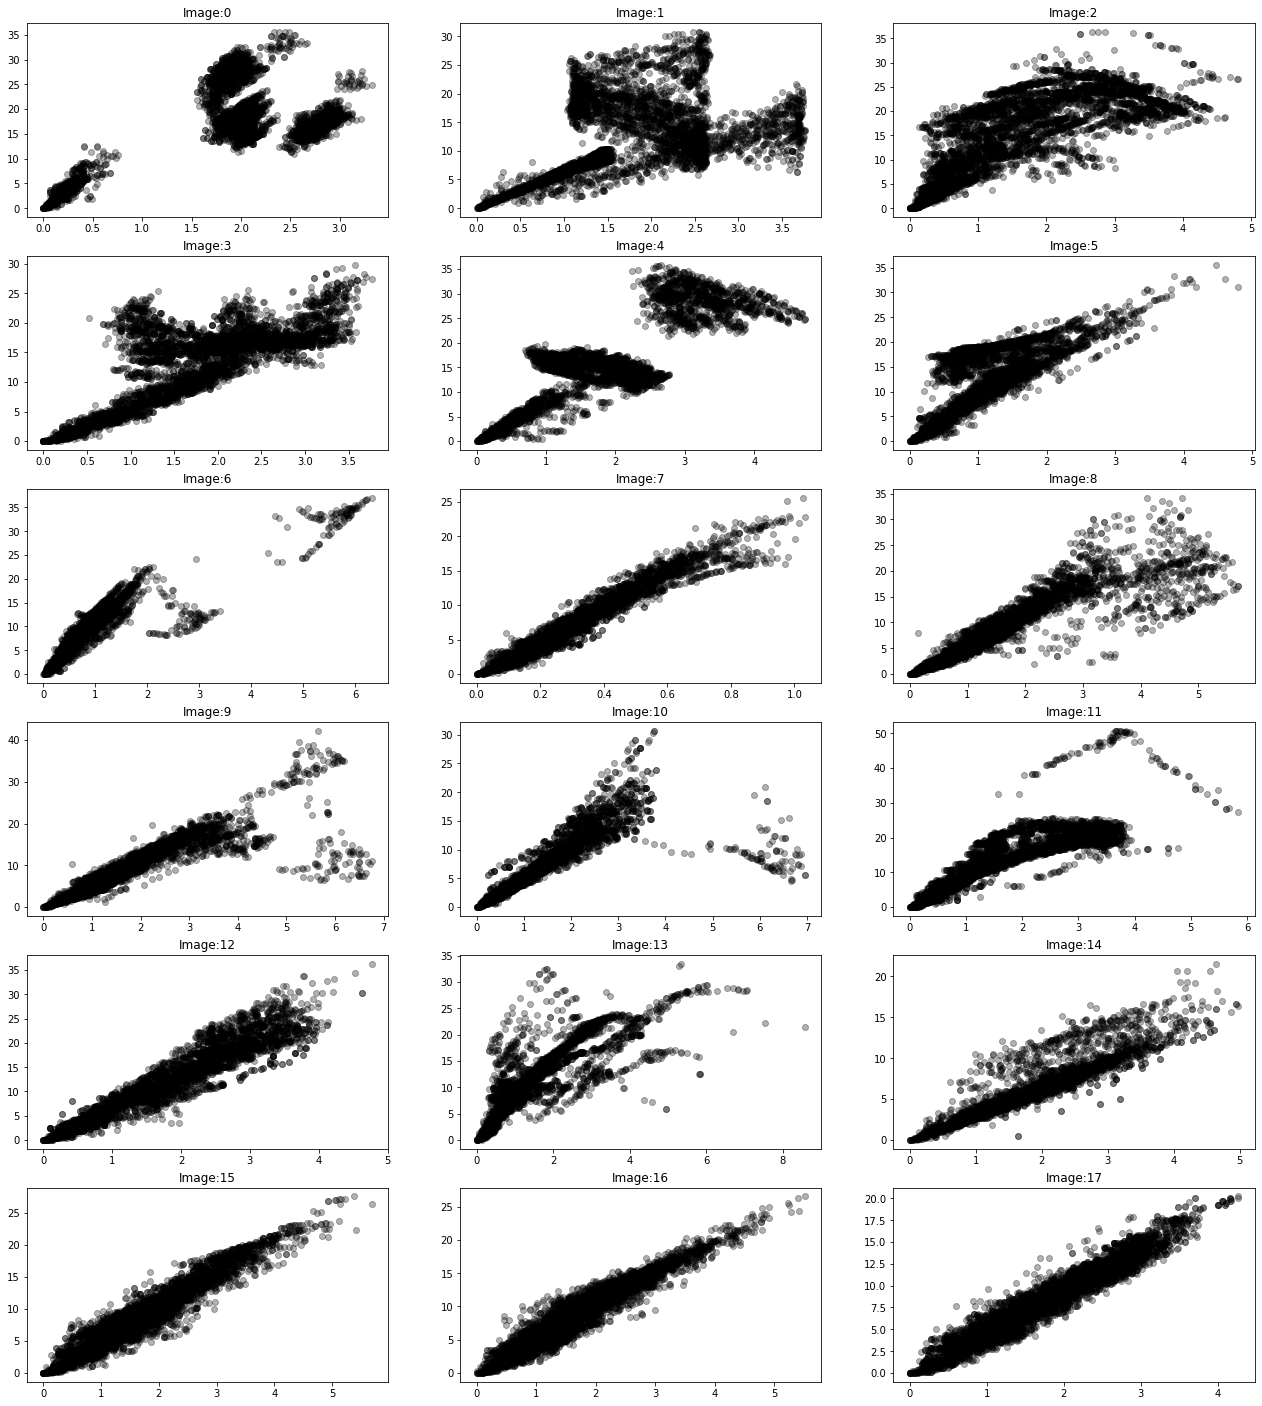

In [39]:
fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(22,25))
for k, ds in enumerate(dists):
    j=k%3 
    i=int(k/3)
    ax[i,j].scatter(x=ds['d_or'], y=ds['d_emb'], color='black', alpha=0.3)
    ax[i,j].set_title(f'Image:{k}')

# Multi-dimensional datasets

In [40]:
dimensionality = 100
num_blobs = 5
test_data_multidim = []

rnd_perturbation = np.random.normal(0, 1, (1000,dimensionality))
test_data_multidim.append(('blobs', datasets.make_blobs(n_samples=1000, n_features=dimensionality, centers=num_blobs)[0]+rnd_perturbation))
test_data_multidim.append(('Friedman1', datasets.make_friedman1(n_samples=1000, n_features=dimensionality)[0]+rnd_perturbation))
test_data_multidim.append(('GaussianQuantiles', datasets.make_gaussian_quantiles(n_samples=1000, n_classes=num_blobs, n_features=dimensionality)[0]+rnd_perturbation))
test_data_multidim.append(('MultiLabelClass', datasets.make_multilabel_classification(n_samples=1000, n_classes=num_blobs, n_features=dimensionality)[0]+rnd_perturbation))

In [41]:
num_samples = 1000
sample_size = 200
sample_selection = np.random.randint(0,num_samples, sample_size)

In [63]:
embedder_type = 'trimap'
n_n = 51
reduce_dim = 50
scaler =  StandardScaler() # QuantileTransformer(output_distribution='normal')#  QuantileTransformer(output_distribution='normal')

In [64]:

embedder = {}
embedder['umap'] = umap.UMAP(n_components=reduce_dim, densmap=True, metric='euclidean',
                             n_neighbors=n_n, min_dist=0., disconnection_distance=1.)
embedder['trimap'] = trimap.TRIMAP(n_dims=reduce_dim, n_iters=2500)
embedder['pacmap'] = pacmap.PaCMAP(n_dims=reduce_dim, n_neighbors=n_n)
embedder['SpectralEmbedding'] = SpectralEmbedding(n_components=reduce_dim, n_neighbors=n_n)
embedder['Isomap'] = Isomap(n_components=reduce_dim)
embedder['MDS'] = MDS(n_components=reduce_dim)
embedder['KernelPCA'] = KernelPCA(n_components=reduce_dim, kernel='sigmoid')
embedder['PCA'] = PCA(n_components=reduce_dim)
embedder['dbmap'] = dbmap.diffusion.Diffusor(n_components=120, ann_dist='euclidean')
embedder['LLE'] = LLE(n_components=reduce_dim, n_neighbors=111, method='ltsa')
embedder['NMF'] = NMF(n_components=reduce_dim, max_iter=10000)
embedder['TSNE'] = TSNE(n_components=3, perplexity=50)
embedder['Sammon'] = graph_clustering.Sammon(n_components=reduce_dim, n_neighbors=n_n,
                                            max_iterations=250, learning_rate=0.05, init_type='PCA')
#embedder['MVU']
#embedder['GSOM']
#embedder['MetricMap']
#embedder['SparseMap']

test_sets_embedded = []
if embedder_type == 'dbmap':
    pipe = Pipeline([('scaler', scaler), 
                     ('prepmap', embedder['dbmap']), 
                     ('reducer', embedder['umap'])])
    for _, ts in tqdm(test_data_multidim):
        tts = embedder['dbmap'].fit_transform(ts)
        test_sets_embedded.append(np.array(pipe.fit_transform(tts)))
elif embedder_type == 'NMF':    
    for _, ts in tqdm(test_data_multidim):
        nonnegger = lambda x: x + 2*np.abs(np.min(x, axis=0))
        nonnegger_F = FunctionTransformer(func=nonnegger)

        pipe = Pipeline([('scaler', scaler), 
                         ('nngr', nonnegger_F), 
                         ('reducer', embedder['NMF'])])
        test_sets_embedded.append(pipe.fit_transform(ts)) 
else:
    pipe = Pipeline([('scaler', scaler), 
                     ('reducer', embedder[embedder_type])])
    for _, ts in tqdm(test_data_multidim):
        test_sets_embedded.append(pipe.fit_transform(ts))

  0%|          | 0/4 [00:00<?, ?it/s]

TRIMAP(n_inliers=10, n_outliers=5, n_random=5, distance=euclidean, lr=1000.0, n_iters=2500, weight_adj=500.0, apply_pca=True, opt_method=dbd, verbose=True, return_seq=False)
running TriMap on 1000 points with dimension 100
pre-processing
found nearest neighbors
sampled triplets
running TriMap with dbd
Iteration:  100, Loss: 38.148, Violated triplets: 0.0694
Iteration:  200, Loss: 37.082, Violated triplets: 0.0674
Iteration:  300, Loss: 35.890, Violated triplets: 0.0653
Iteration:  400, Loss: 34.743, Violated triplets: 0.0632
Iteration:  500, Loss: 33.965, Violated triplets: 0.0618
Iteration:  600, Loss: 33.389, Violated triplets: 0.0607
Iteration:  700, Loss: 32.938, Violated triplets: 0.0599
Iteration:  800, Loss: 32.572, Violated triplets: 0.0592
Iteration:  900, Loss: 32.266, Violated triplets: 0.0587
Iteration: 1000, Loss: 32.005, Violated triplets: 0.0582
Iteration: 1100, Loss: 31.779, Violated triplets: 0.0578
Iteration: 1200, Loss: 31.581, Violated triplets: 0.0574
Iteration: 13

 25%|██▌       | 1/4 [00:57<02:53, 57.88s/it]

Iteration: 2500, Loss: 30.153, Violated triplets: 0.0548
Elapsed time: 0:00:57.877343
running TriMap on 1000 points with dimension 100
using stored triplets
running TriMap with dbd
Iteration:  100, Loss: 42.197, Violated triplets: 0.0767
Iteration:  200, Loss: 39.647, Violated triplets: 0.0721
Iteration:  300, Loss: 37.439, Violated triplets: 0.0681
Iteration:  400, Loss: 35.680, Violated triplets: 0.0649
Iteration:  500, Loss: 34.620, Violated triplets: 0.0629
Iteration:  600, Loss: 33.885, Violated triplets: 0.0616
Iteration:  700, Loss: 33.334, Violated triplets: 0.0606
Iteration:  800, Loss: 32.901, Violated triplets: 0.0598
Iteration:  900, Loss: 32.546, Violated triplets: 0.0592
Iteration: 1000, Loss: 32.249, Violated triplets: 0.0586
Iteration: 1100, Loss: 31.995, Violated triplets: 0.0582
Iteration: 1200, Loss: 31.774, Violated triplets: 0.0578
Iteration: 1300, Loss: 31.579, Violated triplets: 0.0574
Iteration: 1400, Loss: 31.406, Violated triplets: 0.0571
Iteration: 1500, Loss

 50%|█████     | 2/4 [01:57<01:56, 58.32s/it]

Iteration: 2500, Loss: 30.239, Violated triplets: 0.0550
Elapsed time: 0:00:59.332681
running TriMap on 1000 points with dimension 100
using stored triplets
running TriMap with dbd
Iteration:  100, Loss: 42.226, Violated triplets: 0.0768
Iteration:  200, Loss: 39.656, Violated triplets: 0.0721
Iteration:  300, Loss: 37.437, Violated triplets: 0.0681
Iteration:  400, Loss: 35.673, Violated triplets: 0.0649
Iteration:  500, Loss: 34.610, Violated triplets: 0.0629
Iteration:  600, Loss: 33.875, Violated triplets: 0.0616
Iteration:  700, Loss: 33.325, Violated triplets: 0.0606
Iteration:  800, Loss: 32.892, Violated triplets: 0.0598
Iteration:  900, Loss: 32.538, Violated triplets: 0.0592
Iteration: 1000, Loss: 32.241, Violated triplets: 0.0586
Iteration: 1100, Loss: 31.988, Violated triplets: 0.0582
Iteration: 1200, Loss: 31.767, Violated triplets: 0.0578
Iteration: 1300, Loss: 31.573, Violated triplets: 0.0574
Iteration: 1400, Loss: 31.400, Violated triplets: 0.0571
Iteration: 1500, Loss

 75%|███████▌  | 3/4 [02:57<00:58, 58.83s/it]

Iteration: 2500, Loss: 30.235, Violated triplets: 0.0550
Elapsed time: 0:01:00.006225
running TriMap on 1000 points with dimension 100
using stored triplets
running TriMap with dbd
Iteration:  100, Loss: 42.273, Violated triplets: 0.0769
Iteration:  200, Loss: 39.686, Violated triplets: 0.0722
Iteration:  300, Loss: 37.456, Violated triplets: 0.0681
Iteration:  400, Loss: 35.687, Violated triplets: 0.0649
Iteration:  500, Loss: 34.622, Violated triplets: 0.0629
Iteration:  600, Loss: 33.886, Violated triplets: 0.0616
Iteration:  700, Loss: 33.335, Violated triplets: 0.0606
Iteration:  800, Loss: 32.901, Violated triplets: 0.0598
Iteration:  900, Loss: 32.546, Violated triplets: 0.0592
Iteration: 1000, Loss: 32.249, Violated triplets: 0.0586
Iteration: 1100, Loss: 31.995, Violated triplets: 0.0582
Iteration: 1200, Loss: 31.773, Violated triplets: 0.0578
Iteration: 1300, Loss: 31.579, Violated triplets: 0.0574
Iteration: 1400, Loss: 31.406, Violated triplets: 0.0571
Iteration: 1500, Loss

100%|██████████| 4/4 [03:59<00:00, 59.80s/it]

Iteration: 2500, Loss: 30.239, Violated triplets: 0.0550
Elapsed time: 0:01:01.958611


In [65]:
#fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,25))
#for k, ds in enumerate(test_sets_embedded):
#    j=k%2 
#    i=int(k/2)
#    ax[i,j].scatter(x=ds[:,0], y=ds[:,1], color='black')
#    ax[i,j].set_title(f'Image:{k}')

In [66]:
dist_preservation_overall = []
dists = []
for num in tqdm(range(0,4)):
    dist_or = get_intra_sample_distances(test_data_multidim[num][1][sample_selection,:])
    dist_emb = get_intra_sample_distances(test_sets_embedded[num][sample_selection,:])

    dists.append({'d_or': dist_or, 'd_emb': dist_emb})
    dist_preservation_overall.append({'dataset': test_data_multidim[num][0], 
                              'corr':dcor.distance_correlation(dist_or, dist_emb)})

100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


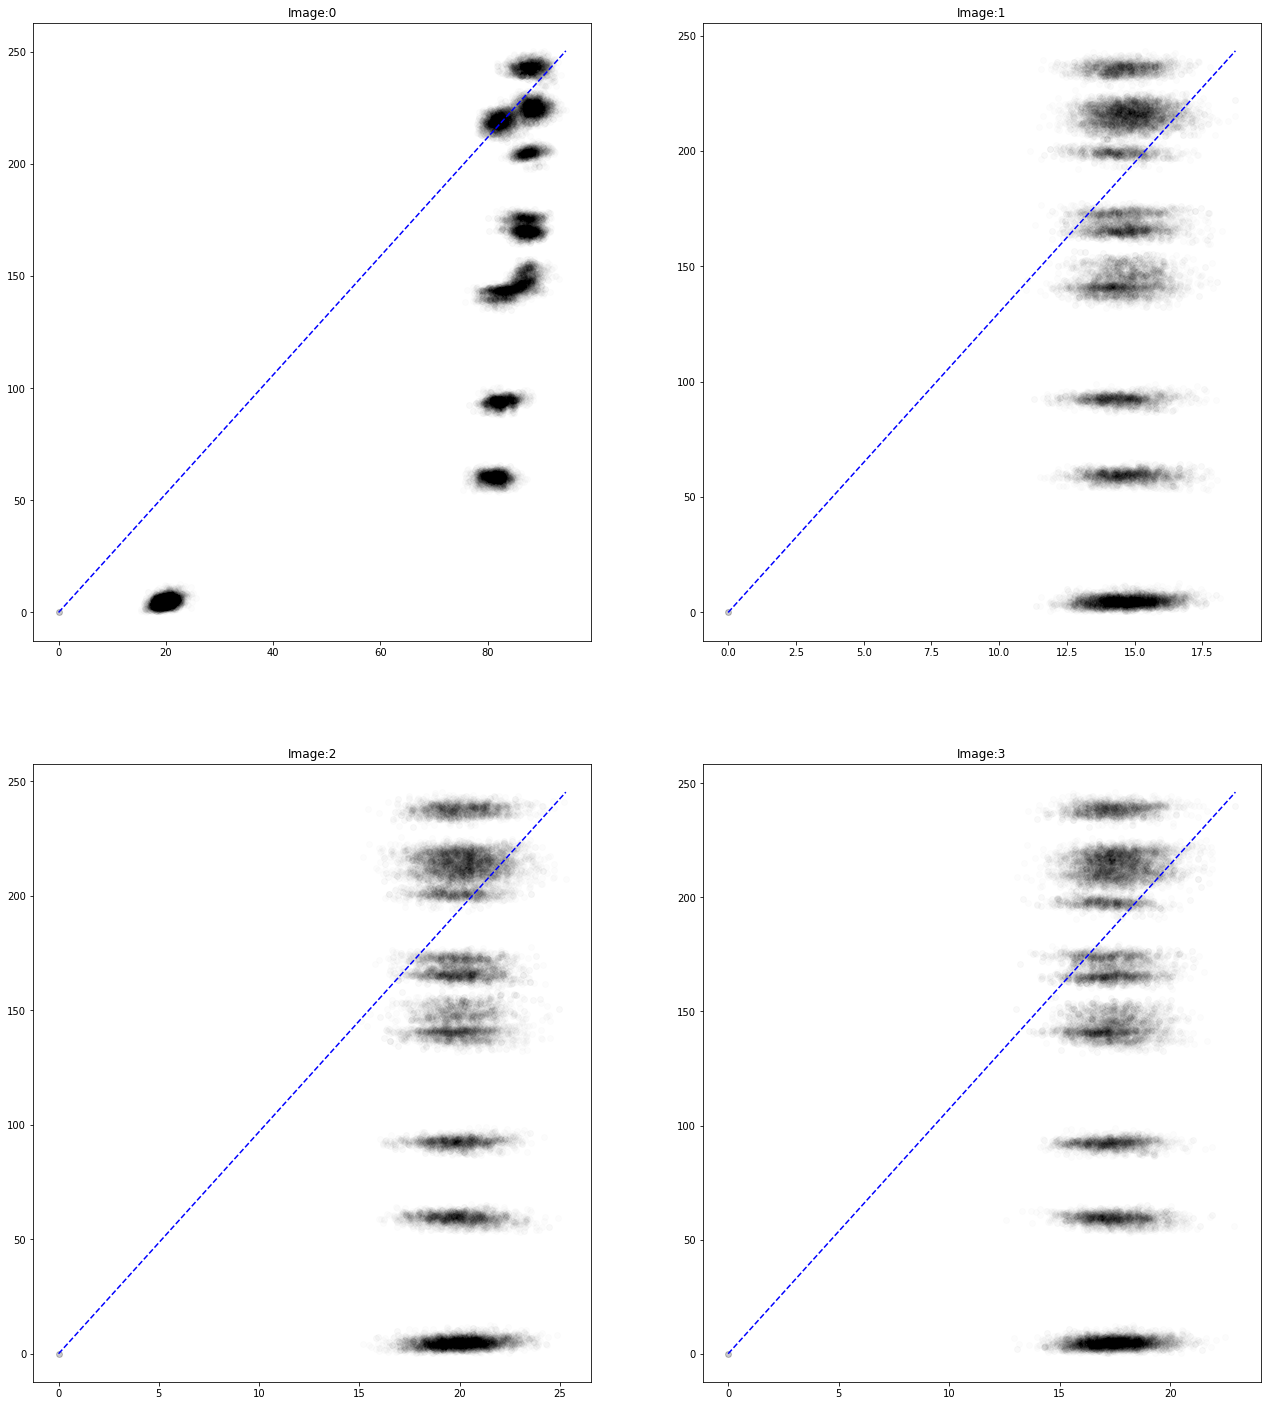

In [67]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,25))
for k, ds in enumerate(dists):
    j=k%2 
    i=int(k/2)
    ax[i,j].scatter(x=ds['d_or'], y=ds['d_emb'], color='black', alpha=0.01)
    mx,my = max(ds['d_or']), max(ds['d_emb'])
    ax[i,j].plot([0,mx], [0, my], ls='--', c='blue')
    ax[i,j].set_title(f'Image:{k}')

In [68]:
dist_preservation_overall

[{'dataset': 'blobs', 'corr': 0.8169701057217972},
 {'dataset': 'Friedman1', 'corr': 0.038401331035642014},
 {'dataset': 'GaussianQuantiles', 'corr': 0.029859941337575763},
 {'dataset': 'MultiLabelClass', 'corr': 0.031612641575114404}]

# Test on genomic data

In [ ]:
# RNA expression data from ~1000 lung cancer patients


# Semi-supervised UMAP

The main flavor is to add labels for the different clusters we know we want to 
see. This can be based on a clustering on a sample set of the original data (perhaps also a selection of features).

# Parametric UMAP

* Create nearest-neighbor graph with fuzzy simplicials
* Apply graph embedder

# Anchored embedding

# Distance preserving embedding

* Siamese twins networks
* distance as outcome
* pairs as input

# Ranking based embedder

# Multi-patch UMAP

The core assumption of UMAP is that all points lie on the same manifold.